<a href="https://colab.research.google.com/github/angelili/publish_code/blob/master/Introduction_to_pFedMe_using_Flower_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction to pFedMe, pFedMe_new


Coming from personalized FL, pFedMe, pFedMe_new, aim to treat data heterogenity.
Alongside the strandard loss of the client, we optimize also for the penalty term, which controls the personalized model $\theta$ of the client remaining close to the global model x. Mathematically the main objective is:
$$\min_{x\in \mathbb{R}^d} \Bigl\{ F(x) := \frac{1}{n} \sum_{i=1}^n F_i(x) \Bigr\}$$
$$ \text{where} \quad F_i(x) := \min_{\theta _i\in \mathbb{R}^d}\Bigl\{ f_i(\theta_i)+ \frac{\lambda}{2} \big\|\theta_i - x \big\|^2 \Bigr\} $$

So pFedme algorithm is outlined as follows:


*     At a global round $t= 0,\ldots, T-1$ server broadcasts the global model $x_t$ to each client $i$
*   At local round, the local model is set $r=0$ $x_{i,0}^t=x_t$



*   At a local round $r=0, \ldots, R-1$ the client samples a batch $D_i$ and takes for $k=0, \ldots, K-1$ steps using some  optimizer:

$$\tilde{f}_i(\theta_i; \mathcal{D}_i)+ \frac{\lambda}{2} \big\|\theta_i - x_{i,r}^t\big\|^2 $$
*   After K iterations obtains $\tilde{\theta}_i(x_{i,r}^t)$ the personliazed model approximate
*   Computes the new local model which signifies the end of one local round!
   $$x_{i,r+1}^t=x_{i,r}^t-\eta\underbrace{\lambda(x_{i,r}^t-\tilde{\theta}_i(x_{i,r}^t)}_{:=\nabla F_i(x_{i,r}^t)}$$

*     Server uniformly samples a subset of clients $\mathcal{S}^t$ with size $S$, each of the sampled client sends the \textbf{local} model $x_{i,R}^t$ to the server


*    Server updates the global model: $x_{t+1}=(1-\beta)x_t + \beta \sum_{i \in \mathcal{S}^t} \frac{x_{i,R}^t}{S}$

The difference between pfedme and pfedme_new is in local iterations & batch sampling:


In this notebook, we'll build a federated learning system simulation using Flower and PyTorch. The clients here a virtualized using ray.
More information could be found on:



Let's get stated!

## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`) and Flower (`flwr`):

In [3]:
!pip install -q flwr[simulation] torch torchvision matplotlib

Now that we have all dependencies installed, we can import everything we need for this introduction:

In [4]:
import flwr as fl
from flwr.common import Metrics

from collections import OrderedDict

from typing import Callable, List, Optional, Tuple, Union, Dict

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST


from typing import List, Optional, Tuple, Union

from torch.utils.data import ConcatDataset, Dataset, Subset, random_split, DataLoader


s

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.1.0+cu118 and Flower 1.5.0


It is neccesary to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware acclerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, I wouldn't reccommend CPU.


### Loading the data

In this introduction, we introduce pFedMe, pFedMe_new by training a simple convolutional neural network (CNN) on the popular FashionMNIST dataset, for image classification on 10 virtual clients.


Ofcourse, we also set up the settings for our simulation.


In [1]:
pFedMe=True
#follow_up, do you want to use pfedme_new?
new=True
num_global_rounds=50
batch_size=32


In [5]:
def download_data() -> Tuple[Dataset, Dataset]:
    """Download (if necessary) and returns the FashionMNIST dataset.

    Returns
    -------
    Tuple[FashionMNIST, FashionMNIST]
        The dataset for training and the dataset for testing FashionMNIST.
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.2859), (0.3530))]
    )
    trainset = FashionMNIST("./dataset", train=True, download=True, transform=transform)
    testset = FashionMNIST("./dataset", train=False, download=True, transform=transform)
    return trainset, testset

To simulate having heterogeneous datasets for each client we use the power_law_split function. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, just to have a heteogenous settup, one could implement ofcourse, a different dataset, and then tailor the (C)NN to its needs.


In [6]:
def sort_by_class(trainset: Dataset) -> Dataset:
    """Sort dataset by class/label.

    Parameters
    ----------
    trainset : Dataset
        The training dataset that needs to be sorted.

    Returns
    -------
    Dataset
        The sorted training dataset.
    """
    class_counts = np.bincount(trainset.targets)   #numpy array
    idxs = trainset.targets.argsort()  # sort targets in ascending order

    tmp = []  # create subset of smallest class
    tmp_targets = []  # same for targets

    start = 0
    for count in np.cumsum(class_counts): #iterate through the cumulative sum of class counts, one iteration is one class
        tmp.append(
            Subset(trainset, idxs[start : int(count + start)])
        )  # add rest of classes
        tmp_targets.append(trainset.targets[idxs[start : int(count + start)]])
        start += count
    sorted_dataset = ConcatDataset(tmp)  # concat dataset
    sorted_dataset.targets = torch.cat(tmp_targets)  # concat targets

    return sorted_dataset


Power_law_split distributes in a cycle manner num_of_labels classes to each client, for example if num_of_labels=5:

1.   Client_1 [0,1,2,3,4]
2.   Client_2 [1,2,3,4,5] and so on

After the initial minimum granting of samples from distinct classes to clients, following a power_law distribution the rest of the samples are given (from
their distinct classes)

In [7]:
def power_law_split(
    sorted_trainset: Dataset,
    num_partitions: int = 10,
    num_labels_per_partition: int = 5,
    min_data_per_partition: int = 10,
    mean: float = 0.0,
    sigma: float = 2.0,
) -> List[Dataset]:
    """Partition the dataset following a power-law distribution.

    Parameters
    ----------
    sorted_trainset : Dataset
        The training dataset sorted by label/class.
    num_partitions: int
        Number of partitions to create.
    num_labels_per_partition: int
        Number of labels to have in each dataset partition.
    min_data_per_partition: int
        Minimum number of datapoints included in each partition.
    mean: float
        Mean value for LogNormal distribution to construct power-law.
    sigma: float
        Sigma value for LogNormal distribution to construct power-law.

    Returns
    -------
    List[Dataset]
        The partitioned training datasets.
    """
    targets = sorted_trainset.targets
    full_idx = list(range(len(targets)))

    class_counts = np.bincount(sorted_trainset.targets)
    labels_cs = np.cumsum(class_counts)
    labels_cs = [0] + labels_cs[:-1].tolist()  #used to determine where each class begins and ends in the sorted dataset

    partitions_idx: List[List[int]] = [] # this list will be used to store the indices of samples that belong to each partition.
    num_classes = len(np.bincount(targets))
    hist = np.zeros(num_classes, dtype=np.int32)

    # assign min_data_per_partition
    min_data_per_class = int(min_data_per_partition / num_labels_per_partition)
    for u_id in range(num_partitions): #iterates over partitions

        partitions_idx.append([])
        for cls_idx in range(num_labels_per_partition): # select samples for different class labels

            cls = (u_id + cls_idx) % num_classes # determine which class to select samples from,  each partition will sample from different classes in a cyclical manner

            indices = list(
                full_idx[
                    labels_cs[cls]
                    + hist[cls] : labels_cs[cls]
                    + hist[cls]
                    + min_data_per_class
                ]
            )  #start:stop
            partitions_idx[-1].extend(indices) # Add the selected indices to the current partition
            hist[cls] += min_data_per_class

    # add remaining images following power-law
    probs = np.random.lognormal(
        mean,
        sigma,
        (num_classes, int(num_partitions / num_classes), num_labels_per_partition),
    )
    remaining_per_class = class_counts - hist

    # obtain how many samples each partition should be assigned for each of the labels it contains
    probs = (
        remaining_per_class.reshape(-1, 1, 1)
        * probs
        / np.sum(probs, (1, 2), keepdims=True)
    )

    for u_id in range(num_partitions):
        for cls_idx in range(num_labels_per_partition):
            cls = (u_id + cls_idx) % num_classes
            count = int(probs[cls, u_id // num_classes, cls_idx])
            # add count of specific class to partition
            indices = full_idx[
                labels_cs[cls] + hist[cls] : labels_cs[cls] + hist[cls] + count
            ]
            partitions_idx[u_id].extend(indices)
            hist[cls] += count

    # construct subsets
    partitions = [Subset(sorted_trainset, p) for p in partitions_idx]

    return partitions




Let's now download the FashionMNIST training and test set. In the load_datasets function, we sort the training set, so we can use the powerlaw function on it. The powerlaw yields the heterogeneous partitions. Then we wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them, and by doing so creating batches for each client.



In [8]:
trainset, testset=download_data()

In [9]:

def load_datasets(  # pylint: disable=too-many-arguments
    num_clients: int,
    val_ratio: float = 0.1,
    batch_size: Optional[int] = 32,
    seed: Optional[int] = 42,
) -> Tuple[DataLoader, DataLoader, DataLoader]:

    # Split each partition into train/test and create DataLoader

    trainset_sorted = sort_by_class(trainset)
    datasets = power_law_split(
    trainset_sorted,
    num_labels_per_partition=5,
    min_data_per_partition=10,
    mean=0.0,
    sigma=2.0)

    trainloaders = []
    testloaders = []
    for dataset in datasets:
        len_val = int(len(dataset) / (1 / val_ratio))
        lengths = [len(dataset) - len_val, len_val]
        ds_train, ds_val = random_split(
            dataset, lengths, torch.Generator().manual_seed(seed)
        )
        trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True))
        testloaders.append(DataLoader(ds_val, batch_size=batch_size))

    return trainloaders, testloaders, DataLoader(testset, batch_size=batch_size)

In [ ]:
trainloaders, testloaders, testset = load_datasets(
        num_clients=10,
        batch_size=batch_size,
    )

In [10]:
trainloaders, testloaders, testset=load_datasets(num_clients=10)

In [11]:
#checking the class distribution on a partition
class_counts = {}  # Dictionary to store counts per class

for data, targets in trainloaders[6]:
    for label in targets:
        if label.item() not in class_counts:
            class_counts[label.item()] = 0
        class_counts[label.item()] += 1

# Print the counts per class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

Class 8: 3711 samples
Class 6: 3397 samples
Class 9: 3702 samples
Class 0: 1426 samples
Class 7: 22 samples


Loading the data into the partitions

We now have a list of ten training sets and ten validation sets (`trainloaders` and `testloaders`) representing the data of ten different clients. Each `trainloader`/`testloader`. There's also a single `testset` (we did not split the test set), which will be placed on the server. Again, this is only necessary for building research, since in really the server should not contain any private data.


In [ ]:

class Net(nn.Module):

    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: Tensor) -> Tensor:
        """Compute forward pass."""
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 4* 4)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x


Here is the main core of this project, it is the pFedMe, pFedMe_new implemented in Pytorch using the Flower framework

In [12]:
def train_pfedme(
        model: nn.Module,
        trainloader: DataLoader,
        new: bool,
        local_rounds: int,
        local_iterations: int,
        device: torch.device,
        lambda_reg: int,
        lr: float,
        mu: float):
    # Copy the parameters obtained from the server (global model), this is done because of the penalty term

    global_params = [val.detach().clone() for val in model.parameters()]
    model.train()
    # Local update on client
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for r in range(local_rounds):
        if new==False:  #important step, sample batch for the local round, never resample in the same local round
            data_iterator = iter(trainloader)
            data, target = next(data_iterator)
            data, target = data.to(device), target.to(device) #sample a batch
            for i in range(local_iterations):
                optimizer.zero_grad()
                proximal_term = 0.0
                for local_weights, global_weights in zip(model.parameters(), global_params):  #here
                    penalty_term += (local_weights - global_weights).norm(2)**2
                loss = criterion(model(data), target) + (lambda_reg/2) * penalty_term
                loss.backward()
                optimizer.step()
        else:  #sample a batch for every local iteration in the local round
            for i in range(local_iterations):
                data_iterator = iter(trainloader)
                data, target = next(data_iterator)
                data, target = data.to(device), target.to(device) #sample a batch
                optimizer.zero_grad()
                proximal_term = 0.0
                for local_weights, global_weights in zip(model.parameters(), global_params):
                    penalty_term += (local_weights - global_weights).norm(2)**2
                loss = criterion(model(data), target) + (lambda_reg/2) * penalty_term
                loss.backward()
                optimizer.step()

        #at the end of each local round after local_iterations happen, update the local(global_params) model according to the personalized model
        with torch.no_grad():
            for param, global_param in zip(model.parameters(), global_params):
                global_param -= mu * lambda_reg * (global_param - param)

    return global_params  #at the end we are left with a personalized model (model.parameters()), and local (global_params), this is important for evaluation


def test(
    model: nn.Module,
    testloader: DataLoader,
    device: torch.device,  # pylint: disable=no-member
) -> Tuple[float, float]:
    """Validate the network on the entire test set."""
    # Define loss and metrics
    criterion = nn.CrossEntropyLoss()
    correct, loss = 0, 0.0

    # Evaluate the network
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)  # pylint: disable=no-member
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


In [13]:
def train_fedavg(model: nn.Module,
        trainloader: DataLoader,
        local_epochs: int,
        device: torch.device,
        lr: float):


    model.train()
    #local update on the client
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    for epoch in range(local_epochs):  # loop over the dataset multiple times

        for  data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model for R local roudns on the local data to get the approximate personalized model, takes a step to get the local model  and sends the updated/changed local model paramters to the server.

To enable seamless communication between the clients and server, we have implemented two essential functions: 'set_parameters and 'get_parameters'.

In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [14]:

# Flower Client
class FlowerClient(fl.client.NumPyClient):
    """Flower client implementing FashionMNIST image classification using
    PyTorch."""
    def __init__(self, trainloader, testloader) -> None:
        super().__init__()

        self.model = Net()
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def set_parameters(self, parameters: List[np.ndarray]) -> None:
        # Set model parameters from a list of NumPy ndarrays
        self.model.train()
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, str]) -> List[np.ndarray]:
        self.model.train()
        # Return model parameters as a list of NumPy ndarrays
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):

        pfedme: bool = config['pfedme']

        if pfedme == True:
            new: bool = config['new']
            lambda_reg: int = config["lambda_reg"]
            local_rounds: int = config["local_rounds"]
            local_iterations: int= config["local_iterations"]
            lr: float= config["learning_rate"]
            mu: float= config["global_learning_rate"]

            self.set_parameters(parameters)

            global_params=train_pfedme(model=self.model, trainloader=self.trainloader,
            new=new, device=self.device, local_rounds=local_rounds, local_iterations=local_iterations, lambda_reg=lambda_reg,
            lr=lr, mu=mu)

            loss_person, accuracy_person = test(model=self.model, testloader=self.testloader, device=self.device)
            with torch.no_grad():
             for param, global_param in zip(self.model.parameters(), global_params):
                    param = global_param
            loss_local, accuracy_local = test(model=self.model, testloader=self.testloader, device=self.device)

            return self.get_parameters(self.model), len(self.testloader), {"accuracy_local": float(accuracy_local),"accuracy_person": float(accuracy_person)}
        else:
            local_epochs: int = config['local_epochs']
            lr: float = config["learning_rate"]


            self.set_parameters(parameters)
            train_fedavg(model=self.model, trainloader=self.trainloader, local_epochs=local_epochs, device=self.device, lr=lr)
            loss_local, accuracy_local = test(model=self.model, testloader=self.testloader, device=self.device)

            return self.get_parameters(self.model), len(self.testloader), {"accuracy_local": float(accuracy_local)}

    def evaluate(
        self, parameters: List[np.ndarray], config: Dict[str, str]
    ) -> Tuple[float, int, Dict]:
        # Set model parameters, evaluate model on local test dataset, return result
        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.testloader, self.device)
        return float(loss), len(self.testloader.dataset), {"accuracy": float(accuracy)}



To enable the Flower framework to create clients when necessary, we need to implement a function called client_fn that creates a FlowerClient instance on demand. Flower calls client_fn whenever it needs an instance of one particular client to call fit or evaluate (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short cid

In [15]:
def generate_client_fn(trainloaders, testloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], testloader=testloaders[int(cid)]
        )

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, testloaders)



In [16]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

In [17]:
if pFedMe==True:

        #preparing empty dictionaries for metrics in pfedme, to be filled in each global round
        training_history_acc_dist={"accuracy_global_pfedme": [], "accuracy_local_pfedme": [], "accuracy_personalized_pfedme":[]}
        training_history_acc_cent={'accuracy_centralized_pfedme': []}
        training_history_loss_cent={"loss_centralized_pfedme": []}

        def get_evaluate_fn_pfedme(
            testset: FashionMNIST, dict_acc: Dict, dict_loss: Dict
        ) -> Callable[[fl.common.NDArrays], Optional[Tuple[float, float]]]:
            """Return an evaluation function for centralized evaluation."""

            def evaluate(
              server_round: int, parameters: fl.common.NDArrays, config: Dict[str, Union[int, float, complex]]
              ) -> Optional[Tuple[float, float]]:
              """Use the entire FashionMNIST test set for evaluation."""

              # determine device
              device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
              model = Net()
              params_dict = zip(model.state_dict().keys(), parameters)
              state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
              model.load_state_dict(state_dict, strict=True)

              model.to(device)



              loss, accuracy = test(model, testset, device)
              #testloader = torch.utils.data.DataLoader(testset, batch_size=50)
              #loss, accuracy = mnist.test_global(model, testloader, device)

              dict_acc["accuracy_centralized_pfedme"].append(accuracy)
              dict_loss["loss_centralized_pfedme"].append(loss)
              # return statistics
              return loss, {"accuracy": accuracy}

            return evaluate


        def agg_metrics_train_pfedme(dict: Dict) -> Metrics:
              def evaluate(metrics: List[Tuple[int, Metrics]]) -> Metrics:
                  # Multiply accuracy of each client by number of examples used
                  accuracies_person = [num_examples * m["accuracy_person"] for num_examples, m in metrics]
                  accuracies_local = [num_examples * m["accuracy_local"] for num_examples, m in metrics]
                  examples = [num_examples for num_examples, _ in metrics]

                  dict["accuracy_personalized_pfedme"].append(sum(accuracies_person)/sum(examples))
                  dict["accuracy_local_pfedme"].append(sum(accuracies_local)/sum(examples))


                  # Aggregate and return custom metric (weighted average)
                  return {"accuracy_personalized": sum(accuracies_person)/sum(examples), "accuracy_local": sum(accuracies_local)/sum(examples)}
              return evaluate

        def weighted_average_pfedme(dict: Dict) -> Metrics:
              # Multiply accuracy of each client by number of examples used
              def evaluate (metrics: List[Tuple[int, Metrics]]) -> Metrics:
                  accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
                  examples = [num_examples for num_examples, _ in metrics]
                  dict["accuracy_global_pfedme"].append(sum(accuracies)/sum(examples))
                  # Aggregate and return custom metric (weighted average)
                  return {"accuracy_global": sum(accuracies) / sum(examples)}
              return evaluate

        def fit_config(server_round: int):
                    """Return training configuration dict for each round."""

                    config = {'pfedme':True,
                        'new': new,
                        "lambda_reg":15,
                        "local_rounds":120,
                        "local_iterations":10,
                        "learning_rate": 0.1,
                        "global_learning_rate": 0.005 }
                    return config



        Strategy = fl.server.strategy.FedAvgM(
                min_fit_clients=9,
                min_evaluate_clients=10,
                min_available_clients=10,
                evaluate_fn=get_evaluate_fn_pfedme(testset,training_history_acc_cent, training_history_loss_cent),#centralised evaluation of global model
                fit_metrics_aggregation_fn=agg_metrics_train_pfedme(training_history_acc_dist),
                evaluate_metrics_aggregation_fn=weighted_average_pfedme(training_history_acc_dist),
                on_fit_config_fn=fit_config,

            )


else:

            #preparing empty dictionaries for metrics in fedavg, to be filled in each global round
            training_history_acc_dist={"accuracy_global_fedavg": [], "accuracy_local_fedavg": []}
            training_history_acc_cent={'accuracy_centralized_fedavg': []}
            training_history_loss_cent={"loss_centralized_fedavg": []}


            def get_evaluate_fn_fedavg(
                testset: FashionMNIST, dict_acc: Dict, dict_loss: Dict
            ) -> Callable[[fl.common.NDArrays], Optional[Tuple[float, float]]]:
                """Return an evaluation function for centralized evaluation."""

                def evaluate(
                    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, Union[int, float, complex]]
                ) -> Optional[Tuple[float, float]]:
                    """Use the entire FashionMNIST test set for evaluation."""

                    # determine device
                    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                    model = Net()
                    params_dict = zip(model.state_dict().keys(), parameters)
                    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
                    model.load_state_dict(state_dict, strict=True)

                    model.to(device)



                    loss, accuracy = test(model, testset, device)
                    #testloader = torch.utils.data.DataLoader(testset, batch_size=50)
                    #loss, accuracy = mnist.test_global(model, testloader, device)

                    dict_acc["accuracy_centralized_fedavg"].append(accuracy)
                    dict_loss["loss_centralized_fedavg"].append(loss)
                    # return statistics
                    return loss, {"accuracy": accuracy}

                return evaluate


            def agg_metrics_train_fedavg(dict: Dict) -> Metrics:
              def evaluate(metrics: List[Tuple[int, Metrics]]) -> Metrics:
                  # Multiply accuracy of each client by number of examples used

                  accuracies_local = [num_examples * m["accuracy_local"] for num_examples, m in metrics]
                  examples = [num_examples for num_examples, _ in metrics]

                  dict["accuracy_local_fedavg"].append(sum(accuracies_local)/sum(examples))


                  # Aggregate and return custom metric (weighted average)
                  return {"accuracy_local_fedavg": sum(accuracies_local)/sum(examples)}
              return evaluate

            def weighted_average_fedavg(dict: Dict) -> Metrics:
            # Multiply accuracy of each client by number of examples used
              def evaluate (metrics: List[Tuple[int, Metrics]]) -> Metrics:
                  accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
                  examples = [num_examples for num_examples, _ in metrics]
                  dict["accuracy_global_fedavg"].append(sum(accuracies)/sum(examples))
                  # Aggregate and return custom metric (weighted average)
                  return {"accuracy_global_fedavg": sum(accuracies) / sum(examples)}
              return evaluate



            def fit_config(server_round: int):
                """Return training configuration dict for each round."""

                config = {'pfedme': False,
                    "local_epochs": 2,
                    "learning_rate": 0.1, }
                return config



            Strategy = fl.server.strategy.FedAvgM(
                    min_fit_clients=9,
                    min_evaluate_clients=10,
                    min_available_clients=10,
                    evaluate_fn=get_evaluate_fn_fedavg(testset,training_history_acc_cent, training_history_loss_cent),#centralised evaluation of global model
                    fit_metrics_aggregation_fn=agg_metrics_train_fedavg(training_history_acc_dist),
                    evaluate_metrics_aggregation_fn=weighted_average_fedavg(training_history_acc_dist),
                    on_fit_config_fn=fit_config,

                )







In [18]:
    # Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=num_global_rounds),
    strategy=Strategy,
    client_resources=client_resources)




INFO flwr 2023-10-26 12:59:47,973 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-10-26 12:59:50,686	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-10-26 12:59:52,956 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3923539968.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7847079936.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3923539968.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7847079936.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-10-26 12:59:52,959 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-10-26 12:59:53,000 | app.py:270

After the simualtion is complete, we are going to plot the metrics!

In [19]:

def plot_training_history(training_history, path):
    plt.figure()
    # Iterate over each metric in the training history dictionary
    for metric, values in training_history.items():
        # Create a line plot for the metric
        plt.plot(values, label=metric)

    # Add labels, title, and legend to the plot
    plt.xlabel('Training Round')
    plt.ylabel('Metric Value')
    plt.title('Training History')
    plt.legend()
    plt.savefig(path)
    # Show the plot
    plt.show()

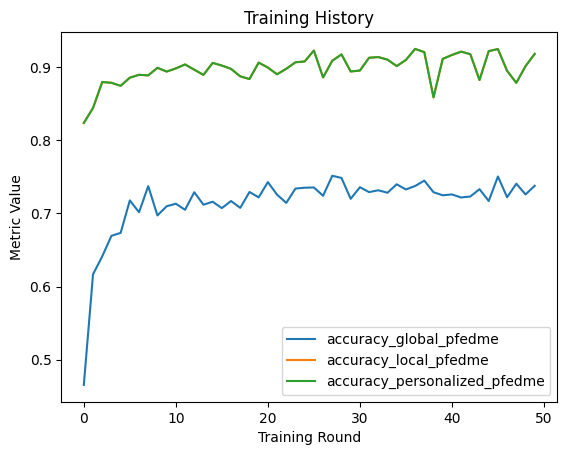

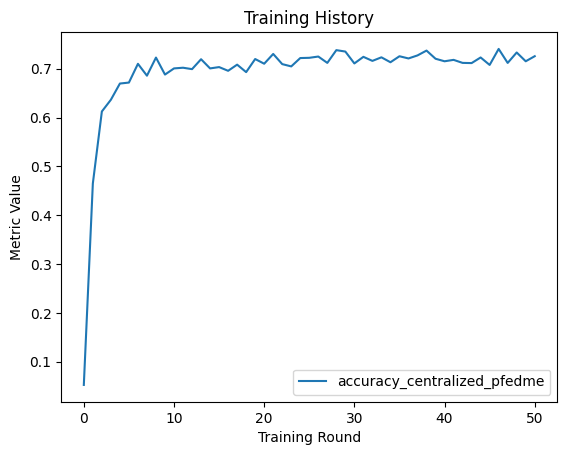

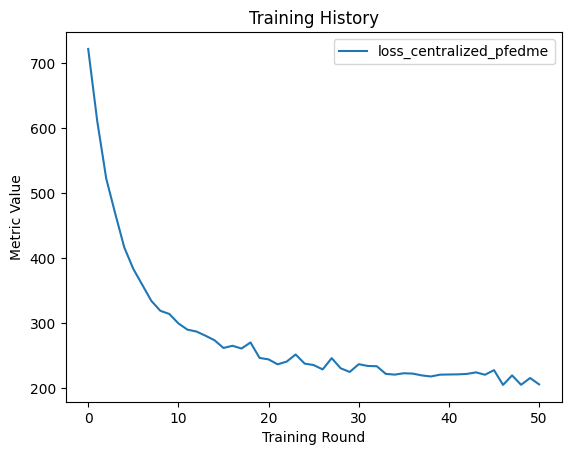

In [20]:
plot_training_history(training_history_acc_dist,'accuracies_on_clients.png')
plot_training_history(training_history_acc_cent,'accuracies_on_server.png')
plot_training_history(training_history_loss_cent,'losses_on_server.png')
